---
authors:
  - name: "Max Jones"
    affiliations:
      - "Development Seed"
    email: "max@developmentseed.org"
    orcid: "0000-0003-0180-8928"
    github: "maxrjones"
---

# ☁️ 4 - Data in the Cloud 101

:::{tip} 🧭 Where we are going
:icon: false

By the end of this module, you will be able to:

- Explain the key benefits and pitfalls of working with data on the Cloud
- Open cloud hosted data in a performant way
- Scale your analyses using Dask or Cubed
- Find communities to learn more about cloud native science
- **Compare performance between local and cloud-based computing**
:::


## Introduction

This notebook is for the workshop ([Open Source Geospatial Workflows in the Cloud](https://geojupyter.github.io/workshop-open-source-geospatial)) presented at the [AGU Fall Meeting 2025](https://agu.confex.com/agu/agu25/meetingapp.cgi/Session/252640).

### 🆕 Local vs. Cloud Comparison Feature

This notebook supports running in both **local** and **cloud** environments to demonstrate the performance benefits of "data-proximate computing". Run it once locally, then again on cloud infrastructure (e.g., AWS us-west-2) to see the dramatic difference in performance when your compute is co-located with your data.

## What is the cloud?

The cloud (as defined by [cloudflare](https://www.cloudflare.com/)) is a distributed collection of servers that host software and infrastructure, and it is accessed over the Internet. The map below (from [salesforce](https://trailhead.salesforce.com/content/learn/modules/aws-cloud-technical-professionals/explore-the-aws-global-infrastructure-technical-professionals)) shows [Amazon Web Service (AWS)](https://aws.amazon.com)'s global distribution of data centers, which contain the resources that make up the AWS cloud. Three large cloud providers in the United States are [AWS](https://aws.amazon.com/), [Google Cloud Platform](https://cloud.google.com/), and [Microsoft Azure](https://azure.microsoft.com/en-us), but other cloud providers are larger elsewhere in the world and there are numerous smaller providers available.

![AWS regions](./aws_regions.jpg)

## What makes data on the cloud different?

Hosting data on the cloud differs from storing data locally (or on-premises) in a few important ways:

- Redundancy - you can easily replicate your data across multiple servers, which may be distributed across the globe
- Reliability - cloud providers offer services for reliability, such as automated backups and recovery
- Scalability - cloud object storage enables nearly limitless simultaneous access across users/connections, without needing to order or decommission servers or hard-drives
- Accessibility - anyone in the world, with proper authorization, can rapidly access data shared on the cloud

Gotchas: There are a couple of considerations to be aware of when working with data on the cloud:

- Pay-as-you-go - Most cloud providers use pay-as-you-go pricing, where you only pay for the storage and services that you use. This can potentially reduce costs, especially upfront costs (e.g., you never need to buy a hard drive). However, **you may want to provide indefinite access or you may forget about data in storage, in both cases you may end up continuing to pay for data storage indefinitely**.
- Time and cost of bringing data to your computer - Hosting the data on the cloud naturally means it's no longer already near your computer's processing resources. Transporting data from the cloud to your computer is expensive, since most cloud providers charge for any data leaving their network, and slow, since the data needs to travel large distances. 

The primary solution for the second bullet, "time and cost bringing data to your computer", is "data-proximate computing" which involves running your code on computing resources in the same cloud location as your data. For example, I commonly use NASA data products that are hosted on AWS servers in the 'us-west-2' region, which corresponds to Oregon in the figure above. Following the "data-proximate computing" paradigm, I use AWS compute resources that are also in Oregon when working with those data, rather than downloading data to use the computing resources on my laptop in North Carolina. In addition to "data-proximate computing", there are many other ways to make working with data on the cloud cheaper and easier. Let's take a look!

## What is cloud-native data?

Cloud-native data are structured for efficient querying across a network. For this 101 tutorial, you can think of "a network" as synonymous with "the internet". You can learn more about these data in the [CNG data formats guide](https://guide.cloudnativegeo.org/), but here we'll just explore working with data that is, compared to data that isn't, optimized for cloud usage.

### Setup and Helper Functions

First import the necessary libraries:

In [1]:
import fsspec
import numpy as np
import xarray as xr
from time import perf_counter
import time  # for timestamps only
import warnings
import json
import os
from pathlib import Path

warnings.filterwarnings(
  "ignore",
  message="Numcodecs codecs are not in the Zarr version 3 specification*",
  category=UserWarning
)

### 🆕 Environment Configuration

Configure whether you're running locally or on cloud infrastructure. This notebook will save timings to a JSON file so you can compare results from different environments.

In [2]:
# =============================================================================
# ENVIRONMENT CONFIGURATION - MODIFY THIS FOR YOUR RUN
# =============================================================================

# Set to "local" when running on your local machine (not in the cloud)
# Set to "cloud" when running on cloud infrastructure (e.g., AWS us-west-2)
ENVIRONMENT = "local"  # Options: "local" or "cloud"

# Optional: Add a description for this run (e.g., your location, machine specs)
RUN_DESCRIPTION = "MacBook Pro - Durham, NC"

# File to store timing results for comparison
TIMINGS_FILE = Path("cloud_data_timings.json")

print(f"🖥️  Running in '{ENVIRONMENT.upper()}' environment")
print(f"📝 Description: {RUN_DESCRIPTION}")

🖥️  Running in 'LOCAL' environment
📝 Description: MacBook Pro - Durham, NC


Set up timing dictionary and helper functions:

In [3]:
# Dictionary to store timings for current run
timings = {
    'open': {},
    'spatial_subset_load': {},
    'time_slice_load': {},
    'timeseries_load': {},
}

# Constants for consistent test parameters
SPATIAL_SUBSET_KWARGS = {"time": "2001-01-02", "lat": slice(10, 15), "lon": slice(-60, -55)}
TIME_SLICE_KWARGS = {"time": "2001-01-10"}
SPATIAL_POINT_KWARGS = {"lat": 45, "lon": -150, "method": "nearest"}
N_FILES = 30

def record_timing(category, method, elapsed_time):
    """Helper to record timing results (using perf_counter for precision)."""
    timings[category][method] = elapsed_time
    print(f"  ⏱️  {category} / {method}: {elapsed_time:.2f}s")


def benchmark_method(ds, method_name, n_files=N_FILES):
    """Run all benchmark tests on a dataset and record timings."""
    
    start = perf_counter()
    data = ds['Tair'].sel(**SPATIAL_SUBSET_KWARGS).load()
    record_timing('spatial_subset_load', method_name, perf_counter() - start)

    start = perf_counter()
    data = ds['Tair'].sel(**TIME_SLICE_KWARGS).load()
    record_timing('time_slice_load', method_name, perf_counter() - start)

    start = perf_counter()
    data = ds['Tair'].sel(**SPATIAL_POINT_KWARGS).isel(time=slice(0, n_files)).load()
    record_timing('timeseries_load', method_name, perf_counter() - start)
    
    return data


def print_summary(method_name):
    """Print a summary of timings for a method."""
    total = sum(timings[op].get(method_name, 0) for op in timings.keys())
    print(f"\n  ┌{'─'*50}")
    print(f"  │ 📋 Summary for {method_name}")
    print(f"  ├{'─'*50}")
    print(f"  │   Open:           {timings['open'].get(method_name, 0):>8.2f}s")
    print(f"  │   Spatial subset: {timings['spatial_subset_load'].get(method_name, 0):>8.2f}s")
    print(f"  │   Time slice:     {timings['time_slice_load'].get(method_name, 0):>8.2f}s")
    print(f"  │   Time series:    {timings['timeseries_load'].get(method_name, 0):>8.2f}s")
    print(f"  ├{'─'*50}")
    print(f"  │   TOTAL:          {total:>8.2f}s")
    print(f"  └{'─'*50}\n")


def load_all_timings():
    """Load all saved timing results from file."""
    if TIMINGS_FILE.exists():
        with open(TIMINGS_FILE, 'r') as f:
            return json.load(f)
    return {}


def save_current_timings():
    """Save current timing results to file."""
    all_timings = load_all_timings()
    
    # Create entry for this run
    run_entry = {
        'description': RUN_DESCRIPTION,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'timings': timings
    }
    
    # Store under environment key
    all_timings[ENVIRONMENT] = run_entry
    
    with open(TIMINGS_FILE, 'w') as f:
        json.dump(all_timings, f, indent=2)
    
    print(f"\n✅ Timings saved to {TIMINGS_FILE}")
    print(f"   Environment: {ENVIRONMENT}")
    print(f"   Timestamp: {run_entry['timestamp']}")


def get_saved_environments():
    """Get list of environments with saved timings."""
    all_timings = load_all_timings()
    return list(all_timings.keys())

List the files available following this pattern on AWS S3 storage:

In [4]:
fs = fsspec.filesystem('s3', anon=True)
nldas_files = fs.glob('s3://nasa-waterinsight/NLDAS3/forcing/daily/**/*.nc')
nldas_files = sorted(['s3://'+f for f in nldas_files])
nldas_files[0]

's3://nasa-waterinsight/NLDAS3/forcing/daily/200101/NLDAS_FOR0010_D.A20010101.030.beta.nc'

### Opening archival data with fsspec + h5netcdf

In [5]:
print(f"\n📊 Testing: fsspec + h5netcdf (default cache)")
start = perf_counter()
fs = fsspec.filesystem('s3', anon=True)
file_objs = [fs.open(f) for f in nldas_files[:N_FILES]]
ds = xr.open_mfdataset(file_objs, engine="h5netcdf", combine="nested", concat_dim="time")
record_timing('open', 'fsspec_default_cache', perf_counter() - start)

benchmark_method(ds, 'fsspec_default_cache')
print_summary('fsspec_default_cache')


📊 Testing: fsspec + h5netcdf (default cache)
  ⏱️  open / fsspec_default_cache: 1819.10s
  ⏱️  spatial_subset_load / fsspec_default_cache: 0.61s
  ⏱️  time_slice_load / fsspec_default_cache: 136.63s
  ⏱️  timeseries_load / fsspec_default_cache: 0.20s

  ┌──────────────────────────────────────────────────
  │ 📋 Summary for fsspec_default_cache
  ├──────────────────────────────────────────────────
  │   Open:            1819.10s
  │   Spatial subset:     0.61s
  │   Time slice:       136.63s
  │   Time series:        0.20s
  ├──────────────────────────────────────────────────
  │   TOTAL:           1956.54s
  └──────────────────────────────────────────────────



In [6]:
[f.close() for f in file_objs]
fs.clear_instance_cache()
del fs, file_objs, ds

This took a lot of time to open the file. Let's look how we can speed that up by configuring the caching strategy:

In [7]:
print(f"\n📊 Testing: fsspec + h5netcdf (block cache)")
start = perf_counter()
fsspec_caching = {
    "cache_type": "blockcache",
    "block_size": 1024 * 1024 * 8,
}
fs = fsspec.filesystem('s3', anon=True)
file_objs = [fs.open(f, **fsspec_caching) for f in nldas_files[:N_FILES]]
ds = xr.open_mfdataset(file_objs, engine="h5netcdf", combine="nested", concat_dim="time")
record_timing('open', 'fsspec_block_cache', perf_counter() - start)

benchmark_method(ds, 'fsspec_block_cache')
print_summary('fsspec_block_cache')


📊 Testing: fsspec + h5netcdf (block cache)
  ⏱️  open / fsspec_block_cache: 278.71s
  ⏱️  spatial_subset_load / fsspec_block_cache: 0.05s
  ⏱️  time_slice_load / fsspec_block_cache: 4.60s
  ⏱️  timeseries_load / fsspec_block_cache: 19.89s

  ┌──────────────────────────────────────────────────
  │ 📋 Summary for fsspec_block_cache
  ├──────────────────────────────────────────────────
  │   Open:             278.71s
  │   Spatial subset:     0.05s
  │   Time slice:         4.60s
  │   Time series:       19.89s
  ├──────────────────────────────────────────────────
  │   TOTAL:            303.25s
  └──────────────────────────────────────────────────



In [8]:
[f.close() for f in file_objs]
fs.clear_instance_cache()
del fs, file_objs, ds

### Opening archival data using VirtualiZarr + Icechunk

Now, for the really cool part! Using [VirtualiZarr](https://virtualizarr.readthedocs.io/) + [Icechunk](https://icechunk.io/), we can rapidly open not just that file but all of the files included in the NLDAS3 dataset! In less than 2 seconds, we can have a lazy view of a dataset that contains 24 years of data. People will often use the term "lazy loading" when an operation loads metadata from a storage location, but does not load any actual data. Without the cloud-native adaptation virtual Zarr, it's not possible for a software library to determine how much data it should load from disk to get all the necessary metadata. Virtual Zarr is a faster, cheaper, and easier way to work with data on the cloud :rocket:.

In [13]:
import icechunk
import zarr
import xarray as xr

zarr.config.set({'threading.max_workers': 32, 'async.concurrency': 128})

In [14]:
print(f"\n📊 Testing: VirtualiZarr + Icechunk")
start = perf_counter()
storage = icechunk.s3_storage(
    bucket='nasa-waterinsight',
    prefix=f"virtual-zarr-store/NLDAS-3-icechunk",
    region="us-west-2",
    anonymous=True,
)

chunk_url = "s3://nasa-waterinsight/NLDAS3/forcing/daily/"
virtual_credentials = icechunk.containers_credentials({
    chunk_url: icechunk.s3_anonymous_credentials()
})

repo = icechunk.Repository.open(
    storage=storage,
    authorize_virtual_chunk_access=virtual_credentials,
)

session = repo.readonly_session('main')
ds = xr.open_zarr(session.store, consolidated=False, zarr_format=3, chunks={})
record_timing('open', 'virtualzarr_icechunk', perf_counter() - start)

benchmark_method(ds, 'virtualzarr_icechunk')
print_summary('virtualzarr_icechunk')
ds


📊 Testing: VirtualiZarr + Icechunk
  ⏱️  open / virtualzarr_icechunk: 2.46s
  ⏱️  spatial_subset_load / virtualzarr_icechunk: 2.53s
  ⏱️  time_slice_load / virtualzarr_icechunk: 5.42s
  ⏱️  timeseries_load / virtualzarr_icechunk: 1.21s

  ┌──────────────────────────────────────────────────
  │ 📋 Summary for virtualzarr_icechunk
  ├──────────────────────────────────────────────────
  │   Open:               2.46s
  │   Spatial subset:     2.53s
  │   Time slice:         5.42s
  │   Time series:        1.21s
  ├──────────────────────────────────────────────────
  │   TOTAL:             11.63s
  └──────────────────────────────────────────────────



<xarray.Dataset> Size: 51TB
Dimensions:   (time: 8399, lat: 6500, lon: 11700)
Coordinates:
  * time      (time) datetime64[ns] 67kB 2001-01-02 2001-01-03 ... 2024-01-01
  * lat       (lat) float64 52kB 7.005 7.015 7.025 7.035 ... 71.97 71.98 71.99
  * lon       (lon) float64 94kB -169.0 -169.0 -169.0 ... -52.03 -52.01 -52.0
Data variables:
    LWdown    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    PSurf     (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Rainf     (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Wind_N    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Qair      (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair      (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Wind_E    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    SWdown    (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair_max  (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
    Tair_min  (time, lat, lon) float64 5TB dask.array<chunksize=(1, 500, 900), meta=np.ndarray>
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        daily
    shortname:              NLDAS_FOR0010_D_3.0
    title:                  NLDAS Forcing Data L4 Daily 0.01 x 0.01 degree V3...
    version:                3.0 beta
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/v3/ ; https://li...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  7.005000114440918
    SOUTH_WEST_CORNER_LON:  -168.9949951171875
    DX:                     0.009999999776482582
    DY:                     0.009999999776482582

### Save Timings for This Environment

In [15]:
# Save the timing results for this environment
save_current_timings()

# Show what environments we have data for
saved_envs = get_saved_environments()
print(f"\n📁 Saved timing data available for: {saved_envs}")


✅ Timings saved to cloud_data_timings.json
   Environment: local
   Timestamp: 2025-12-11 12:18:33

📁 Saved timing data available for: ['cloud', 'local']


## 🆕 Local vs. Cloud Performance Comparison

After running this notebook in both environments, run this section to see the performance differences.

In [4]:
def create_comparison_report():
    """Create a comprehensive comparison between local and cloud runs."""
    all_timings = load_all_timings()
    
    if len(all_timings) < 2:
        missing = []
        if 'local' not in all_timings:
            missing.append('local')
        if 'cloud' not in all_timings:
            missing.append('cloud')
        print(f"⚠️  Need timing data from both environments!")
        print(f"   Missing: {missing}")
        print(f"   Available: {list(all_timings.keys())}")
        print(f"\n   To complete the comparison:")
        print(f"   1. Run this notebook with ENVIRONMENT = 'local' on your local machine")
        print(f"   2. Run this notebook with ENVIRONMENT = 'cloud' on cloud infrastructure (e.g., AWS us-west-2)")
        print(f"   3. Copy the {TIMINGS_FILE} file between environments or manually combine results")
        return None
    
    return all_timings

all_timings = create_comparison_report()

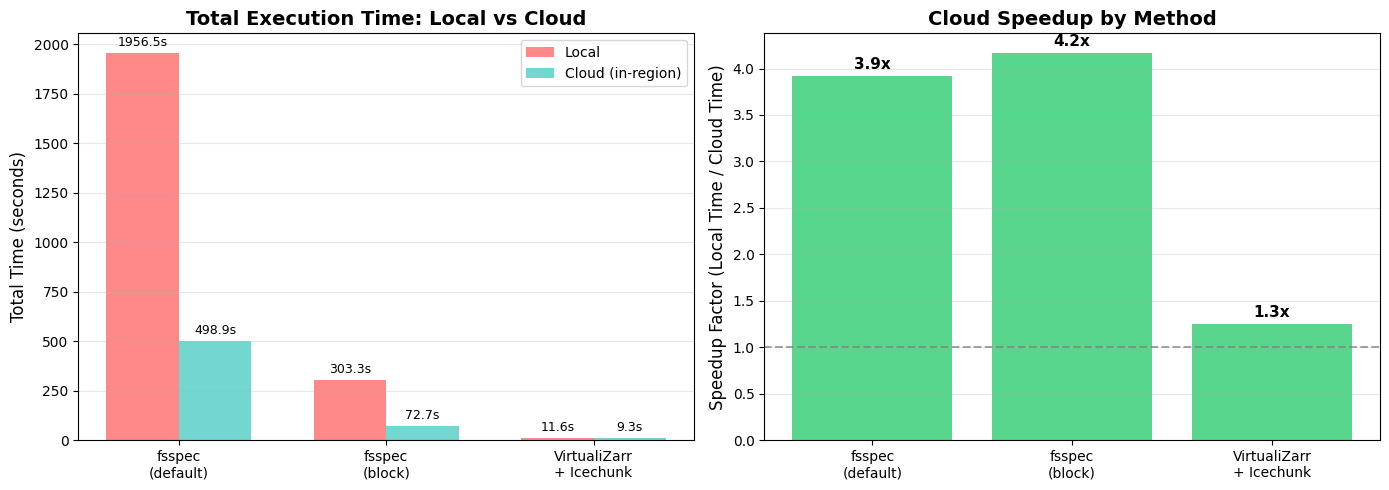


📊 Chart saved to 'local_vs_cloud_comparison.png'


In [5]:
def plot_comparison(all_timings):
    """Create a visual comparison of local vs cloud performance."""
    if all_timings is None:
        return
    
    import matplotlib.pyplot as plt
    
    methods = ['fsspec_default_cache', 'fsspec_block_cache', 'virtualzarr_icechunk']
    method_labels = ['fsspec\n(default)', 'fsspec\n(block)', 'VirtualiZarr\n+ Icechunk']
    
    # Calculate total times for each method
    local_totals = []
    cloud_totals = []
    
    for method in methods:
        local_total = sum(
            all_timings.get('local', {}).get('timings', {}).get(op, {}).get(method, 0)
            for op in ['open', 'spatial_subset_load', 'time_slice_load', 'timeseries_load']
        )
        cloud_total = sum(
            all_timings.get('cloud', {}).get('timings', {}).get(op, {}).get(method, 0)
            for op in ['open', 'spatial_subset_load', 'time_slice_load', 'timeseries_load']
        )
        local_totals.append(local_total)
        cloud_totals.append(cloud_total)
    
    # Create bar chart
    x = np.arange(len(methods))
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Total time comparison
    bars1 = ax1.bar(x - width/2, local_totals, width, label='Local', color='#ff6b6b', alpha=0.8)
    bars2 = ax1.bar(x + width/2, cloud_totals, width, label='Cloud (in-region)', color='#4ecdc4', alpha=0.8)
    
    ax1.set_ylabel('Total Time (seconds)', fontsize=12)
    ax1.set_title('Total Execution Time: Local vs Cloud', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(method_labels, fontsize=10)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    # Speedup comparison
    speedups = [l/c if c > 0 else 0 for l, c in zip(local_totals, cloud_totals)]
    colors = ['#2ecc71' if s > 1 else '#e74c3c' for s in speedups]
    bars3 = ax2.bar(x, speedups, color=colors, alpha=0.8)
    ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.7, label='No speedup')
    ax2.set_ylabel('Speedup Factor (Local Time / Cloud Time)', fontsize=12)
    ax2.set_title('Cloud Speedup by Method', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(method_labels, fontsize=10)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, speedup in zip(bars3, speedups):
        height = bar.get_height()
        ax2.annotate(f'{speedup:.1f}x',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('local_vs_cloud_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Chart saved to 'local_vs_cloud_comparison.png'")

if all_timings:
    plot_comparison(all_timings)

In [6]:
def print_key_insights(all_timings):
    """Print key insights from the comparison."""
    if all_timings is None:
        return
    
    print("\n" + "="*80)
    print("💡 KEY INSIGHTS")
    print("="*80)
    
    # Calculate average speedup
    speedups = []
    methods = ['fsspec_default_cache', 'fsspec_block_cache',  'virtualzarr_icechunk']
    
    for method in methods:
        local_total = sum(
            all_timings.get('local', {}).get('timings', {}).get(op, {}).get(method, 0)
            for op in ['open', 'spatial_subset_load', 'time_slice_load', 'timeseries_load']
        )
        cloud_total = sum(
            all_timings.get('cloud', {}).get('timings', {}).get(op, {}).get(method, 0)
            for op in ['open', 'spatial_subset_load', 'time_slice_load', 'timeseries_load']
        )
        if cloud_total > 0:
            speedups.append((method, local_total / cloud_total, local_total, cloud_total))
    
    if speedups:
        avg_speedup = sum(s[1] for s in speedups) / len(speedups)
        max_speedup = max(speedups, key=lambda x: x[1])
        
        print(f"\n📈 Average speedup from data-proximate computing: {avg_speedup:.1f}x")
        print(f"🏆 Best speedup: {max_speedup[0]} ({max_speedup[1]:.1f}x faster on cloud)")
        
        # Time saved
        total_local = sum(s[2] for s in speedups)
        total_cloud = sum(s[3] for s in speedups)
        time_saved = total_local - total_cloud
        
        print(f"\n⏱️  Total time (all methods):")
        print(f"   Local:  {total_local:.1f} seconds")
        print(f"   Cloud:  {total_cloud:.1f} seconds")
        print(f"   Saved:  {time_saved:.1f} seconds ({(time_saved/total_local)*100:.0f}% reduction)")
        
        print("\n🎯 Key takeaway: Running your code on cloud infrastructure")
        print("   co-located with your data can dramatically improve performance!")

if all_timings:
    print_key_insights(all_timings)


💡 KEY INSIGHTS

📈 Average speedup from data-proximate computing: 3.1x
🏆 Best speedup: fsspec_block_cache (4.2x faster on cloud)

⏱️  Total time (all methods):
   Local:  2271.4 seconds
   Cloud:  580.9 seconds
   Saved:  1690.5 seconds (74% reduction)

🎯 Key takeaway: Running your code on cloud infrastructure
   co-located with your data can dramatically improve performance!


## Takeaways

- When working on the cloud, try to find computing resources that are "in-region" to the data you're working with.
- File formats matter - consider using virtual Zarr if your data are not already "cloud-optimized".
- File access patterns matter - the default arguments for reading data from the cloud may be very slow! You can customize the configuration for better performance.
- **🆕 Data-proximate computing can provide dramatic speedups compared to working locally!**

## References

- [Cloud-Optimized Geospatial Formats Guide](https://guide.cloudnativegeo.org/)
- [Xarray Tutorial - Zarr in Cloud Object Storage](https://tutorial.xarray.dev/intermediate/remote_data/cmip6-cloud.html)
- [Xarray Tutorial - Access Patterns to Remote Data with fsspec](https://tutorial.xarray.dev/intermediate/remote_data/cmip6-cloud.html)
- [ICESAT-2 Cloud Computing Tutorial](https://icesat-2-2024.hackweek.io/tutorials/cloud-computing/00-goals-and-outline.html)
